* produce LDA plots 
    * change alpha value for individual traces 
    * plot average for different morph values with higher alpha
    * start-triggered and reward-triggered PSTH
    
    * look at projection on cells
        * scatter plot with com as location, spatial information as size, projection on LDA as color
        * correlation of magnitude of projection with amount of spatial information
    

In [66]:
#import ipympl
import matplotlib.pyplot as plt

import scipy as sp
import scipy.io
import numpy as np
import os
os.sys.path.append('../behavior')
os.sys.path.append('../')
from behavior_analysis import process_data as pd
from behavior_analysis import loadmat_sbx

import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import pandas 

from utilities import load_ca_mat, trial_tensor, across_trial_avg
import utilities


%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Single Session Analysis

In [5]:
CaDataDir = "Z://2P_data/2AFC_V3/4058541.1/CA1/"
mouse = "4058541.1"
CaFiles = ["CA1_001_004", "CA1_002_008", "CA1_003_002","CA1_004_002","CA1_005_001"] 
vr_dir = "Z://VR/2AFC_V3/"
BehaviorFiles = ["1_imaging_","2_imaging_3_",  "3_", "4_imaging_", "5_imaging_"]

In [212]:
i = 4
info = loadmat_sbx(CaDataDir + "/rawDat/" + CaFiles[i] + ".mat")['info']
sess = "2AFC_Test_PostSurg_" + BehaviorFiles[i]
c = pd(mouse,sess,basedir='work')
behavior,tstart_inds,reward_inds,first_lick_inds = c.align_to_ca(sess,info)

(246,)
(245, 4)


In [213]:
fname= CaDataDir+ CaFiles[i] +"_cnmf_results.mat"
print(fname)
ca_dat = load_ca_mat(fname)


Z://2P_data/2AFC_V3/4058541.1/CA1/CA1_005_001_cnmf_results.mat


In [98]:
C_dec = sp.stats.zscore(ca_dat['C_dec'][behavior['ca_inds'].values,:],axis=0)
C_raw = ca_dat['C_dec'][behavior['ca_inds'].values,:]

In [215]:
# perform dimensionality reduction leaving out morph trials
lda = LDA(n_components=1)
#plt.plot(behavior['rewards'])

# additionally restrict to timepoints before the reward
base_trial_mask = np.where(((behavior['morph'].values==1) | (behavior['morph'].values==0)) & 
                          ((behavior['rewards']==1) | (behavior['rewards']==-1) | 
                           (behavior['rewards']==2)|(behavior['rewards']==-2)))[0]

trial_mask = np.where((behavior['position'].values>0) ) #& (behavior['position'].values<175))



In [64]:
# do Leave-One-Trial-Out cross validation to see how well LDA works to classify activity

#convert tstart and reward indices
tstart_inds_base = np.zeros(behavior['morph'].values.shape)
tstart_inds_base[tstart_inds] = 1
tstart_inds_base = np.where(tstart_inds_base[base_trial_mask]>0)[0]

reward_inds_base = np.zeros(behavior['morph'].values.shape)
reward_inds_base[reward_inds] = 1
reward_inds_base = np.where(reward_inds_base[base_trial_mask]>0)[0]

C_base = C_dec[base_trial_mask,:]
morph_base = behavior['morph'].values[base_trial_mask]

all_inds = np.arange(C_base.shape[0])
last_inds = np.append(tstart_inds_base[1:]-1,C_base.shape[0])
true_labels, majority_vote = [],[]
for i, (first_ind,reward_ind,last_ind) in enumerate(zip(tstart_inds_base.tolist(),reward_inds_base.tolist(),last_inds)):
    trainInds = np.where((all_inds<first_ind) | (all_inds>last_ind))[0]
    testInds = np.where((all_inds>=first_ind) & (all_inds<=last_ind))[0]
    
    C_train,C_test = C_base[trainInds,:],C_base[testInds,:]
    train_labels, test_label = morph_base[trainInds], morph_base[testInds]
    true_labels.append(test_label[0])
    lda = LDA(n_components=1)
    C_train_lda = lda.fit_transform(C_train,train_labels)
    
    y_hat = lda.predict(C_test).mean()
    if y_hat>.5:
        majority_vote.append(1)
        
    else:
        majority_vote.append(0)
        
acc = 0
for guess, true in zip(majority_vote,true_labels):
    if guess == true:
        acc+=1
acc/=len(majority_vote)
        


0 153
154 330
331 489
490 616
617 782
783 909
910 1057
1058 1212
1213 1366
1367 1526
1527 1676
1677 1816
1817 1937
1938 2081
2082 2228
2229 2361
2362 2499
2500 2643
2644 2788
2789 2958
2959 3080
3081 3218
3219 3371
3372 3503
3504 3663
3664 3792
3793 3931
3932 4078
4079 4226
4227 4376
4377 4510
4511 4662
4663 4793
4794 4939
4940 5065
5066 5197
5198 5346
5347 5501
5502 5635
5636 5772
5773 5897
5898 6034
6035 6158
6159 6285
6286 6411
6412 6556
6557 6675
6676 6810
6811 6953
6954 7075
7076 7204
7205 7358
7359 7489
7490 7620
7621 7747
7748 7872
7873 7998
7999 8149
8150 8258
8259 8380
8381 8502
8503 8629
8630 8743
8744 8881
8882 8995
8996 9113
9114 9263
9264 9379
9380 9516
9517 9643
9644 9787
9788 9912
9913 10045
10046 10175
10176 10303
10304 10435
10436 10566
10567 10688
10689 10816
10817 10952
10953 11070
11071 11203
11204 11312
11313 11451
11452 11573
11574 11695
11696 11838
11839 11958
11959 12075
12076 12222
12223 12345
12346 12458
12459 12588
12589 12707
12708 12827
12828 12949
12950 13

In [65]:
print(acc)

0.8367346938775511


In [197]:
lda = LDA(n_components=1)
C_base_lda = lda.fit_transform(C_dec[base_trial_mask,:],behavior['morph'].values[base_trial_mask])
C_lda = lda.transform(C_dec)
C_lda_prob = lda.predict_proba(C_dec)



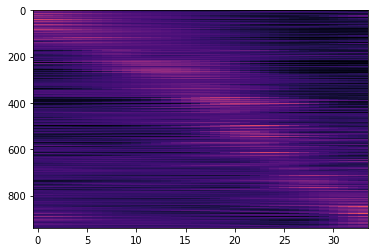

In [198]:
from scipy.ndimage.filters import gaussian_filter

frmap, occupancy = utilities.rate_map(C_raw,behavior['position'].values)


maxInds = np.argmax(frmap,axis=0)
normMat = np.zeros(frmap.shape)
for i in range(frmap.shape[1]):
    normMat[:,i] = gaussian_filter(frmap[:,i],2)/frmap[:,i].sum()
sortVec = np.argsort(maxInds)
#f,ax = plt.subplots(1,1)
plt.imshow(normMat[:,sortVec].T,aspect='auto',cmap='magma')
    
SI = utilities.spatial_info(frmap,occupancy)
#print(SI)

In [199]:
p = utilities.spatial_info_perm_test(SI,C_raw,behavior['position'].values,nperms = 1000)

(446,)


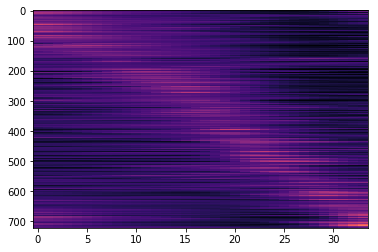

In [200]:
print(np.where(p>.99)[0].shape)
frmap_sig = frmap[:,p>.9]
maxInds = np.argmax(frmap_sig,axis=0)
normMat = np.zeros(frmap_sig.shape)
for i in range(frmap_sig.shape[1]):
    normMat[:,i] = gaussian_filter(frmap_sig[:,i],2)/frmap_sig[:,i].sum()
sortVec = np.argsort(maxInds)
#f,ax = plt.subplots(1,1)
plt.imshow(normMat[:,sortVec].T,aspect='auto',cmap='magma')
    
#SI = utilities.spatial_info(frmap,occupancy)


(9, 100, 1)


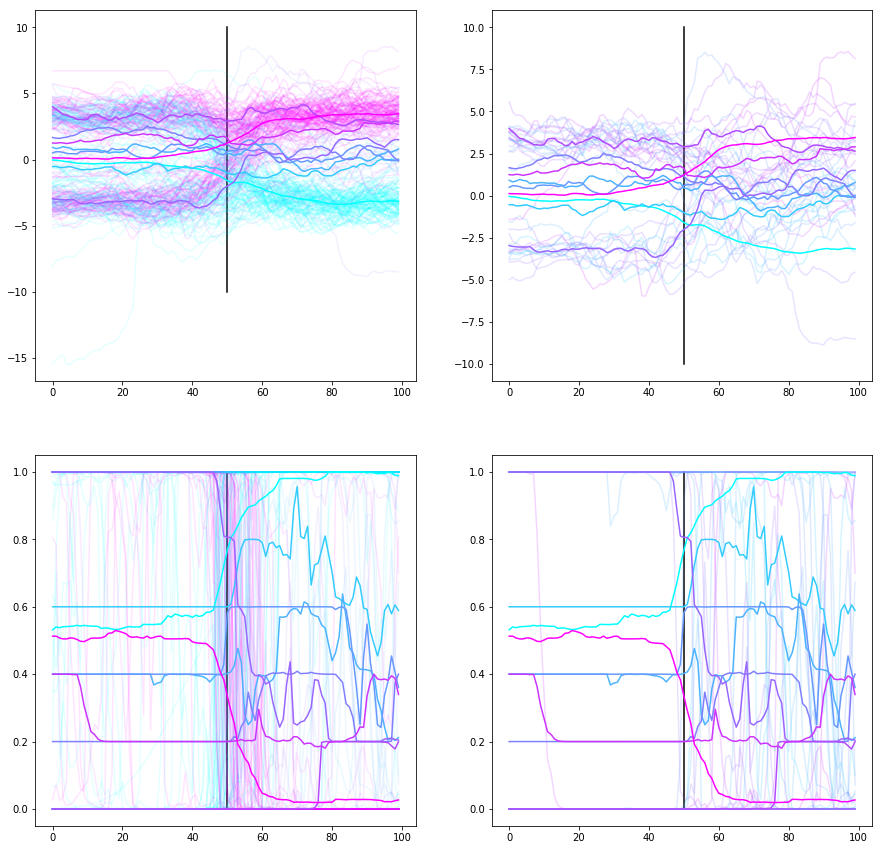

In [114]:

f,ax = plt.subplots(2,2,figsize=[15,15])
#print(len(tstart_inds))

ax[0,0].plot([50, 50], [-10, 10],c='black')
ax[0,1].plot([50, 50], [-10, 10],c='black')
ax[1,0].plot([50, 50], [0, 1],c='black')
ax[1,1].plot([50, 50], [0, 1],c='black')


trialMat_proj, morphVec = trial_tensor(C_lda,behavior['morph'].values,tstart_inds)
trialMat_prob, trash = trial_tensor(C_lda_prob[:,0],behavior['morph'].values,tstart_inds)

morphAvg_proj, morphVals = across_trial_avg(trialMat_proj,morphVec)
morphAvg_prob, morphVals = across_trial_avg(trialMat_prob,morphVec)

#trialMat_proj, morphAvg_proj = np.squeeze(trialMat_proj), np.squeeze(morphAvg_proj)
#trialMat_prob, morphAvg_proj = np.squeeze(trialMat_prob), np.squeeze(morphAvg_prob)
for ind,t in enumerate(tstart_inds.tolist()):
    ax[0,0].plot(trialMat_proj[ind,:,:],c=plt.cm.cool(morphVec[ind]),alpha=.1)
    ax[1,0].plot(trialMat_prob[ind,:,:],c=plt.cm.cool(morphVec[ind]),alpha=.1)
    
    if (morphVec[ind]!=1.0) and (morphVec[ind]!=0.0):
        ax[0,1].plot(trialMat_proj[ind,:,:],c=plt.cm.cool(behavior['morph'].values[t]),alpha=.2)
        ax[1,1].plot(trialMat_prob[ind,:,:],c=plt.cm.cool(behavior['morph'].values[t]),alpha=.2)
        
print(morphAvg_proj.shape)
for i,val in enumerate(morphVals.tolist()):
    ax[0,0].plot(np.squeeze(morphAvg_proj[i,:]),c=plt.cm.cool(val))
    ax[0,1].plot(np.squeeze(morphAvg_proj[i,:]),c=plt.cm.cool(val))
    
    ax[1,0].plot(np.squeeze(morphAvg_prob[i,:]),c=plt.cm.cool(val))
    ax[1,1].plot(np.squeeze(morphAvg_prob[i,:]),c=plt.cm.cool(val))

(9, 100, 1)


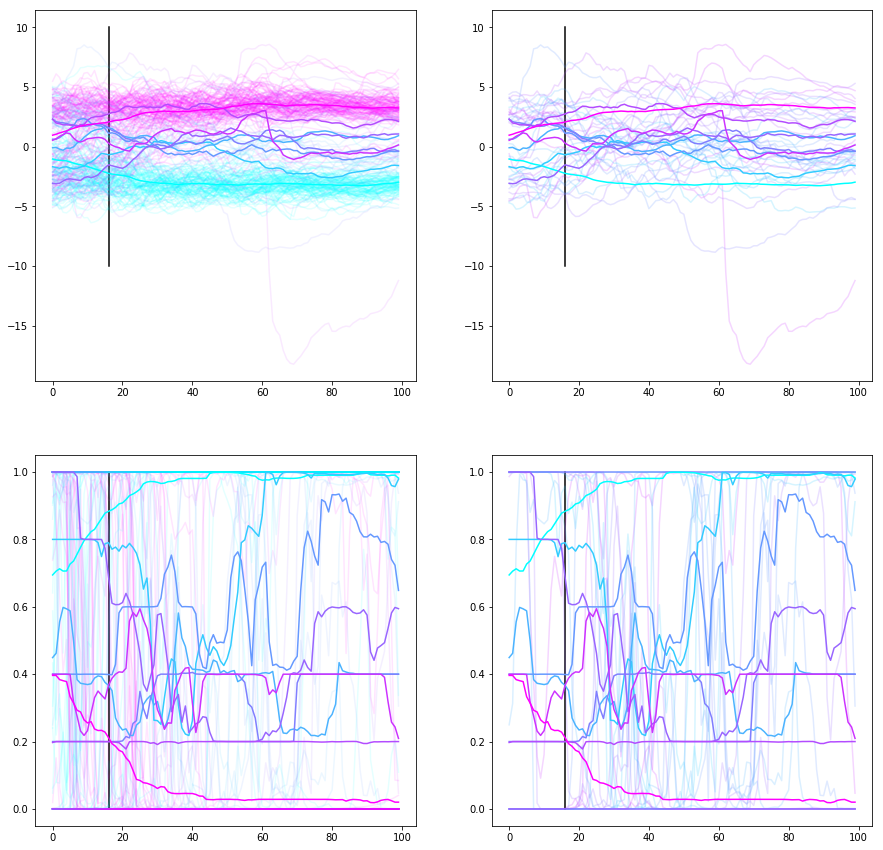

In [217]:
f,ax = plt.subplots(2,2,figsize=[15,15])
#print(len(tstart_inds))

ax[0,0].plot([16, 16], [-10, 10],c='black')
ax[0,1].plot([16, 16], [-10, 10],c='black')
ax[1,0].plot([16, 16], [0, 1],c='black')
ax[1,1].plot([16, 16], [0, 1],c='black')

trialMat_proj, morphVec = trial_tensor(C_lda,behavior['morph'].values,np.array(reward_inds))
trialMat_prob, trash = trial_tensor(C_lda_prob[:,0],behavior['morph'].values,np.array(reward_inds))

morphAvg_proj, morphVals = across_trial_avg(trialMat_proj,morphVec)
morphAvg_prob, morphVals = across_trial_avg(trialMat_prob,morphVec)

for ind,t in enumerate(reward_inds):
    ax[0,0].plot(trialMat_proj[ind,:,:],c=plt.cm.cool(morphVec[ind]),alpha=.1)
    ax[1,0].plot(trialMat_prob[ind,:,:],c=plt.cm.cool(morphVec[ind]),alpha=.1)
    
    if (morphVec[ind]!=1.0) and (morphVec[ind]!=0.0):
        ax[0,1].plot(trialMat_proj[ind,:,:],c=plt.cm.cool(behavior['morph'].values[t]),alpha=.2)
        ax[1,1].plot(trialMat_prob[ind,:,:],c=plt.cm.cool(behavior['morph'].values[t]),alpha=.2)
        
print(morphAvg_proj.shape)
for i,val in enumerate(morphVals.tolist()):
    ax[0,0].plot(np.squeeze(morphAvg_proj[i,:]),c=plt.cm.cool(val))
    ax[0,1].plot(np.squeeze(morphAvg_proj[i,:]),c=plt.cm.cool(val))
    
    ax[1,0].plot(np.squeeze(morphAvg_prob[i,:]),c=plt.cm.cool(val))
    ax[1,1].plot(np.squeeze(morphAvg_prob[i,:]),c=plt.cm.cool(val))



In [218]:

grand_morph_avg_proj =np.zeros(morphVals.shape)
grand_morph_avg_prob =np.zeros(morphVals.shape)

for i, val in enumerate(morphVals.tolist()):
    grand_morph_avg_proj[i] = C_lda[(behavior['morph'].values==val)&(behavior['position'].values>0)].mean()
    grand_morph_avg_prob[i] = C_lda_prob[(behavior['morph'].values==val)&(behavior['position'].values>0),1].mean()

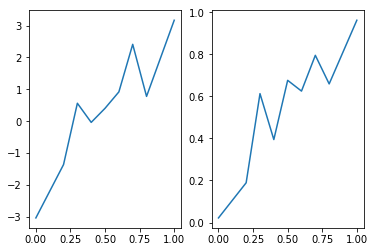

In [219]:
f,ax = plt.subplots(1,2)
ax[0].plot(morphVals,grand_morph_avg_proj)
ax[1].plot(morphVals,grand_morph_avg_prob)

(940,)


Text(0,0.5,'Count')

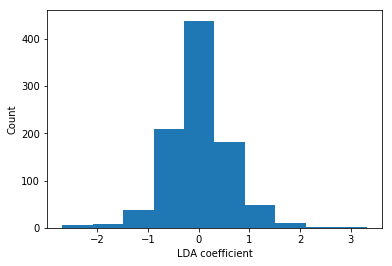

In [190]:
print(lda.coef_.ravel().shape)
f,ax = plt.subplots()
c,bins,patches=ax.hist(lda.coef_.ravel())
ax.set_xlabel('LDA coefficient')
ax.set_ylabel('Count')

spatial information v |LDA coefficient| correlation: -0.154927


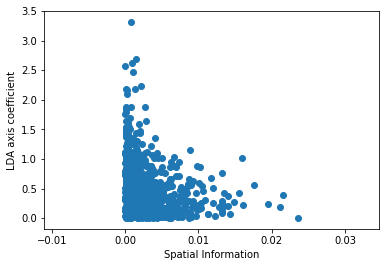

In [195]:
f,ax = plt.subplots()
ax.scatter(SI,np.abs(lda.coef_.ravel()))
ax.set_xlabel('Spatial Information')
ax.set_ylabel('LDA axis coefficient')
r,p = sp.stats.spearmanr(SI,np.abs(lda.coef_.ravel()))
print('spatial information v |LDA coefficient| correlation: %f' % r)

### Plot PSTH for cells with large projection on discriminant axis

# Across Session Analysis

In [28]:
for i in range(5):
    info = loadmat_sbx(CaDataDir + "/rawDat/" + CaFiles[i] + ".mat")['info']
    sess = "2AFC_Test_PostSurg_" + BehaviorFiles[i]
    c = pd(mouse,sess,basedir='work')
    behavior,tstart_inds,reward_inds,first_lick_inds = c.align_to_ca(sess,info)
    
    fname= CaDataDir+ CaFiles[i] +"_cnmf_results.mat"
    ca_dat = load_ca_mat(fname)
    C_dec = sp.stats.zscore(ca_dat['C_dec'][behavior['ca_inds'].values,:],axis=0)
    lda = LDA(n_components=1)
    # additionally restrict to timepoints before the reward
    base_trial_mask = np.where(((behavior['morph'].values==1) | (behavior['morph'].values==0)) & 
                          ((behavior['rewards']==1) | (behavior['rewards']==-1) | 
                           (behavior['rewards']==2)|(behavior['rewards']==-2)))[0]
                           
                           
    trial_mask = np.where((behavior['position'].values>0) ) 
    
    C_base_lda = lda.fit_transform(C_dec[base_trial_mask,:],behavior['morph'].values[base_trial_mask])
    if i == 0:
        C_lda_prob = lda.predict_proba(C_dec)
        trialMat_prob_reward, morphVec = trial_tensor(C_lda_prob[:,0],behavior['morph'].values,np.array(reward_inds))
        trialMat_prob_start, morphVec = trial_tensor(C_lda_prob[:,0],behavior['morph'].values,tstart_inds,pre=15,post =50)
        position, rewards, morphs = behavior['position'].values,behavior['rewards'].values, behavior['morph'].values
        
    else:
        C_lda_tmp = lda.predict_proba(C_dec)
        C_lda_prob = np.append(C_lda_prob,C_lda_tmp,axis=0)
        #print(C_lda_prob.shape)
        tmp_prob_reward, tmp_morphVec = trial_tensor(C_lda_tmp[:,0],behavior['morph'].values,np.array(reward_inds))
        tmp_prob_start, tmp_morphVec = trial_tensor(C_lda_tmp[:,0],behavior['morph'].values,tstart_inds,pre=15,post=50)
        
        trialMat_prob_reward= np.append(trialMat_prob_reward,tmp_prob_reward,axis=0)
        trialMat_prob_start= np.append(trialMat_prob_start,tmp_prob_start,axis=0)
        morphVec = np.append(morphVec,tmp_morphVec,axis=0)
        position = np.append(position,behavior['position'].values)
        rewards = np.append(rewards,behavior['rewards'].values)
        morphs = np.append(morphs,behavior['morph'].values)
        
   

(120,)
(119, 4)
(246,)
(245, 4)
(240,)
(239, 4)
(178,)
(177, 4)
#subsystem#not made into numpy array
(246,)
(245, 4)


(146165, 2) (146165,) (146165,)


Text(0.5,1,'Average Probability')

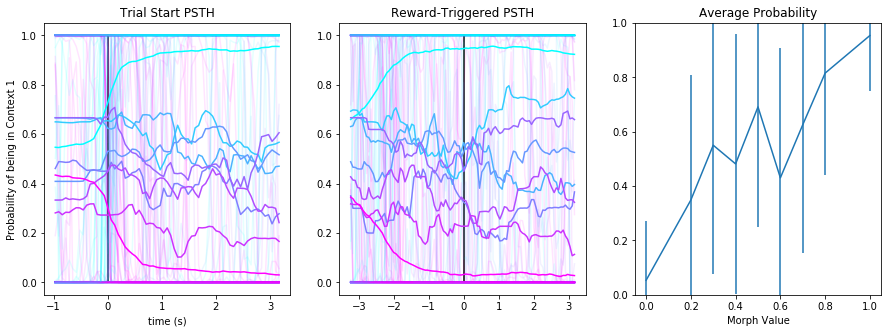

In [40]:
f,ax = plt.subplots(1,3,figsize=[15,5])
morphAvg_prob_start, morphVals = across_trial_avg(trialMat_prob_start,morphVec)
morphAvg_prob_reward, morphVals = across_trial_avg(trialMat_prob_reward,morphVec)


grand_avg_prob =np.zeros(morphVals.shape)
sem_prob = np.zeros(morphVals.shape)
print(C_lda_prob.shape, morphs.shape, position.shape)
for i, val in enumerate(morphVals.tolist()):
    grand_avg_prob[i] = C_lda_prob[(morphs==val)&(position>0),1].mean()
    sem_prob[i] = np.std(C_lda_prob[(morphs==val)&(position>0),1],axis=0)
    
ax[0].plot([0, 0], [0, 1],c='black')
ax[1].plot([0, 0], [0, 1],c='black')

for ind,t in enumerate(tstart_inds):
    ax[0].plot(np.arange(-15,50)/15.46,trialMat_prob_start[ind,:,:],c=plt.cm.cool(morphVec[ind]),alpha=.1)
    ax[1].plot(np.arange(-50,50)/15.46,trialMat_prob_reward[ind,:,:],c=plt.cm.cool(morphVec[ind]),alpha=.1)

for ind,val in enumerate(morphVals.tolist()):
    ax[0].plot(np.arange(-15,50)/15.46,morphAvg_prob_start[ind,:],c=plt.cm.cool(val))
    ax[1].plot(np.arange(-50,50)/15.46,morphAvg_prob_reward[ind,:],c=plt.cm.cool(val))

    
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('Probability of being in Context 1')
ax[0].set_title('Trial Start PSTH')
ax[1].set_title('Reward-Triggered PSTH')
#ax[2].plot(morphVals,grand_avg_prob)
ax[2].errorbar(morphVals,grand_avg_prob,yerr=sem_prob)
ax[2].set_xlabel('Morph Value')
ax[2].set_ylim([0,1])
ax[2].set_title('Average Probability')


In [ ]:
g